<a href="https://colab.research.google.com/github/GreatLearningAIML1/delhi-may19-batch-Trapti04/blob/master/CV_Project2_Dog_Breed_Classification_Questions__TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astor, numpy, absl-py, tensorflow-estimator, termcolor, wheel, tensorboard, opt-einsum, six, grpcio, keras-preprocessing, wrapt, gast, protobuf, scipy, keras-applications, google-pasta
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 3.8MB 51.8MB/s 
     |████████████████████████████████| 450kB 64.4MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# import libraries

In [0]:
 import pandas as pd
 import numpy as np
 from tqdm import tqdm
 import cv2

 import matplotlib.pyplot as plt

 from sklearn.model_selection import train_test_split

 # Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

import tensorflow.keras.preprocessing.image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Dataset Files

Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/DogBreed_Classification/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
with ZipFile(project_path+'test.zip', 'r') as tst:
 tst.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
#with ZipFile(project_path+'sample_submission.csv.zip', 'r') as sam:
 #   sam.extractall()

Repeat the same step for labels.csv.zip

In [0]:
with ZipFile(project_path+'labels.csv.zip', 'r') as lbl:
 lbl.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels_df = pd.read_csv("./labels.csv")

In [12]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [13]:
labels_df.size

20444

### Print the count of each category of Dogs given in the dataset



In [14]:
#print(labels_df.groupby('breed').count())
count_category = labels_df.groupby('breed').count()
count_category

,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
...,...
welsh_springer_spaniel,79
west_highland_white_terrier,81
whippet,95


In [15]:
 plt.figure(figsize=(12,7))

<Figure size 864x504 with 0 Axes>

<Figure size 864x504 with 0 Axes>

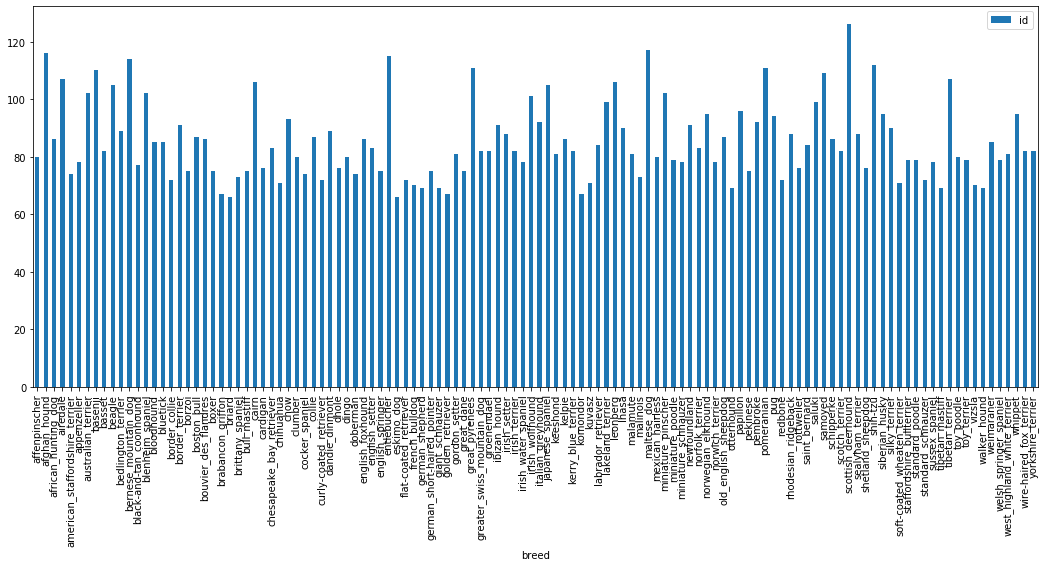

In [16]:
count_category.plot(kind = 'bar', figsize =(18,7),)

### Get one-hot encodings of labels

In [17]:
labels_series = pd.Series(labels_df['breed'])
one_hot = pd.get_dummies(labels_series, sparse = True)
one_hot_labels = np.asarray(one_hot)
one_hot_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
one_hot_labels.size

1226640

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [19]:
HEIGHT = 224
WIDTH = 224
CHANNEL = 3

x_train_data = []
y_train_data = []

i = 0 

for f, breed in tqdm(labels_df.values):
    img = cv2.imread('./train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train_data.append(cv2.resize(img, (HEIGHT, WIDTH)))
    y_train_data.append(label)
    i += 1

100%|██████████| 10222/10222 [00:34<00:00, 292.63it/s]


Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
#X = np.array(x_train_data, dtype="float") / 255.0
Y = np.array(y_train_data,np.uint8)

In [0]:
X = np.array(x_train_data, dtype="float") 

In [22]:
X.shape

(10222, 224, 224, 3)

In [23]:
Y.shape

(10222, 120)

In [24]:
# clean up memory of x_train_data and y_train_data which has been moved into X/Y
import gc

x_train_data=pd.DataFrame()
y_train_data=pd.DataFrame()
del [[x_train_data,y_train_data]]
gc.collect()


215

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
 x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 

In [0]:
#x_train1,x_discard,y_train1,y_discard = train_test_split(X, Y, test_size=0.50, random_state=1) # discarding half the training set due to  RAM issues

In [0]:
# = train_test_split(x_train1, y_train1, test_size=0.3, random_state=1)

In [28]:
x_train_data=pd.DataFrame()
Y=pd.DataFrame()
del [[X,Y]]
gc.collect()

0

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
#test_df = pd.read_csv('./sample_submission.csv')

In [0]:
#test_df.head()

In [0]:
#test_img = test_df['id']

Run the below code to load the test image files in x_test_feature

In [0]:
#x_test_feature = []
#i = 0 # initialisation
#for f in tqdm(test_img.values): # f for format ,jpg
#    img = cv2.imread('./test/{}.jpg'.format(f))
#    img_resize = cv2.resize(img, (HEIGHT, WIDTH)) 
#    x_test_feature.append(img_resize)

Normalize the test data and convert it into 4 dimensions

In [0]:
#x_test_sub = np.array(x_test_feature, dtype="float32") / 255.0

In [0]:
#x_test_sub.shape

## Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
BATCH_SIZE = 128
EPOCHS = 30

input_shape = (HEIGHT,WIDTH,3)

### Use batch_size = 128 and epochs = 10 and execute the model

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('/content/drive/My Drive/Computer vision/Project2_CNN/'+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [37]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [38]:
# Fully Connected Layer
x = base_model.output

x = Flatten()(x)

x = Dense(1024,activation='relu')(x) #dense layer 1

x = Dropout(0.6)(x) # adding a drop put to prevent overfitting

x = Dense(512,activation='relu')(x) #dense layer 1

x = Dropout(0.4)(x)

x = Dense(256,activation='relu')(x) #dense layer 2

# Prediction Layer
preds = Dense(120,activation='softmax')(x) #final layer with softmax activation


In [0]:
from tensorflow.keras.models import Model

model= Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

### Make all the layers in the base_model (VGG16) to be non-trainable

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_datagen_new = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies


In [0]:
train_generator_transfer = train_datagen_new.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [0]:
val_datagen_new = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

In [0]:
val_generator_transfer = val_datagen_new.flow(x_test, y_test, batch_size=BATCH_SIZE)

Try to get training and validation accuracy to be more than 90%

In [48]:
model.fit(train_generator_transfer, epochs=EPOCHS, validation_data = val_generator_transfer)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56 steps, validate for 24 steps
Epoch 1/30
56/56 [==============================] - 281s 5s/step - loss: 5.3861 - accuracy: 0.0200 - val_loss: 4.5555 - val_accuracy: 0.0708
Epoch 2/30
56/56 [==============================] - 280s 5s/step - loss: 4.2879 - accuracy: 0.0730 - val_loss: 3.5122 - val_accuracy: 0.2035
Epoch 3/30
56/56 [==============================] - 280s 5s/step - loss: 3.4095 - accuracy: 0.1774 - val_loss: 2.6098 - val_accuracy: 0.3313
Epoch 4/30
56/56 [==============================] - 281s 5s/step - loss: 2.8245 - accuracy: 0.2595 - val_loss: 2.2393 - val_accuracy: 0.4046
Epoch 5/30
56/56 [==============================] - 284s 5s/step - loss: 2.5377 - accuracy: 0.3107 - val_loss: 2.0670 - val_accuracy: 0.4431
Epoch 6/30
56/56 [==============================] - 283s 5s/step - loss: 2.3258 - accuracy: 0.3554 - val_loss: 1.9391 - val_accuracy: 0.4679
Epoch 7/30
56/56 [==============================] - 283s 5s/st

KeyboardInterrupt: ignored

In [0]:
#With image input size 128; 50% of dataset we have a overfitting problem and accuracy of validation is .30 against train accuracy .99. Hence discarded.
# With image input size 128; 100% of dataset we have a overfitting problem and accuracy of validation is .28 against train accuracy .99, Hence discarded.
# achieved .45 accuracy with Image size 224 and model is overfit after 10 epochs with Batch size 128.
# achieved .44 accuracy with Image size 224 and model is overfit after 10 epochs with Batch size 256.
# adding drop out 0.2 increases the accuracy  to .46
#with drop of out 0.5 accuracy is 0.49 in 15 epochs with batch size 128
# with drop of 0.5 introduced with an additional dense layer Trn acc = .69 validation 0.56
# with increase is drop to 0.8 and 0.5 respectively validation accuracy achieve is 0.51 with 30 epocha.
# Drop is changed to 0.6 and 0.4 respectvely. The training is more healthy we see that training and testing accuarcy beginning to match 
# after balance after 14th epoch. by the 21st epoch we can see that training accuracy is increasing marginally [~0.63] test is not.
# it stagnates at 0.56 percent.

# further trial can included lowering the drop out rate further to see if training improves.
# implement callback on tempering the learning rate to achieve faster convergence in training.
# open one the last convo layer also for training. That may improve the rate further.

In [0]:
model.save('dog_breed_model.h5') 